# Covid-19 Data EDA and Forecast Modeling

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Tweet_Analysis

## Introduction

### Problem and Purpose

This project will use forecasting to model Covid-19 deaths  based on current hospital, infection, and death data. I will be using API html links to bring in up to date data regularly. My project will use supervised learning in the form of ARIMA and SARIMAX in order to predict future numbers.

Create easily viewable and customizable visualizations about Covid-19 deaths. If time allows, the project will involve building a dashboard to showcase the data. 

## Table of Contents

### Standard Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
import plotly.express as px
import plotly.io as pio
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
import pandas_datareader as pdr
import holidays
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output,State
# app = JupyterDash('our app')
# pio.templates

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
scaler = MinMaxScaler()

In [11]:
import warnings
warnings.filterwarnings('ignore')

### Custom Libraries

In [12]:
from Cust_Func import adf_test
from Cust_Func import create_SARIMA_summary_forecast_state as cas_state
from Cust_Func import create_SARIMA_summary_forecast_usa as cas_usa
from Cust_Func import create_SARIMAX_summary_forecast_state as create_SAX
from Cust_Func import create_SARIMAX_summary_forecast_usa as create_SAX_usa
from Cust_Func import create_NN_predict as create_nn
from Cust_Func import clean_dataframe as clean_df

## Explore Data

### Create New DataFrame

In [13]:
df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

In [14]:
df_states.info

<bound method DataFrame.info of            state  positive  probableCases   negative  pending  \
date                                                            
2021-01-23    AK   51445.0            NaN  1395069.0      NaN   
2021-01-23    AL  439442.0        91425.0  1730471.0      NaN   
2021-01-23    AR  282995.0        56108.0  2111634.0      NaN   
2021-01-23    AS       0.0            NaN     2140.0      NaN   
2021-01-23    AZ  715357.0        43328.0  2657166.0      NaN   
...          ...       ...            ...        ...      ...   
2020-01-17    WA       0.0            NaN        NaN      NaN   
2020-01-16    WA       0.0            NaN        NaN      NaN   
2020-01-15    WA       0.0            NaN        NaN      NaN   
2020-01-14    WA       0.0            NaN        NaN      NaN   
2020-01-13    WA       NaN            NaN        NaN      NaN   

              totalTestResultsSource  totalTestResults  hospitalizedCurrently  \
date                                     

In [15]:
df_states.tail().index[0:100]

DatetimeIndex(['2020-01-17', '2020-01-16', '2020-01-15', '2020-01-14',
               '2020-01-13'],
              dtype='datetime64[ns]', name='date', freq=None)

In [16]:
df_states = df_states.dropna(subset=['death'])

In [17]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17494 entries, 2021-01-23 to 2020-02-10
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        17494 non-null  object 
 1   positive                     17446 non-null  float64
 2   probableCases                7816 non-null   float64
 3   negative                     17316 non-null  float64
 4   pending                      1658 non-null   float64
 5   totalTestResultsSource       17494 non-null  object 
 6   totalTestResults             17473 non-null  float64
 7   hospitalizedCurrently        15055 non-null  float64
 8   hospitalizedCumulative       11237 non-null  float64
 9   inIcuCurrently               9725 non-null   float64
 10  inIcuCumulative              3276 non-null   float64
 11  onVentilatorCurrently        7743 non-null   float64
 12  onVentilatorCumulative       1121 non-null   float64
 13 

In [18]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [19]:
state_postal = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY']

### Create DataFrame for Each State Deaths

In [20]:
# create a dataframe for each state, visualize data

In [21]:
df_begin = 'df_{state}'
df_list = []

In [22]:
df_states.sort_index()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-02-10,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,04c672d9235d9aeb73fb20462d13e41ab325b456,0,0,0,0,0,NaN
2020-02-11,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,c517cc2a1c11e114c74f683aa30f00b560b61652,0,0,0,0,0,NaN
2020-02-12,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,dc77f570d79d1398d81a9b86c99f901f37c5e0fe,0,0,0,0,0,NaN
2020-02-13,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,b0269e519c685d2937b037df7dbe4a12b325a603,0,0,0,0,0,NaN
2020-02-14,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,6d74e2c9d73e5222e1819cf58d39a59dd19bffee,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-23,NE,186255.0,NaN,711753.0,NaN,totalTestsViral,1998438.0,414.0,5670.0,NaN,...,898008,10,23,ef885f30f0d908f02becc2f1ff559695b91a43fa,0,0,0,0,0,NaN
2021-01-23,ND,96720.0,4044.0,293468.0,NaN,totalTestEncountersViral,1323998.0,50.0,3739.0,6.0,...,390188,0,3,fd15a4899338226bab4dd39d79c4ea58a8246dbc,0,0,0,0,0,NaN
2021-01-23,NC,712716.0,72280.0,7749846.0,NaN,posNeg,8462562.0,3416.0,NaN,736.0,...,8462562,122,0,27a7a1357d7aca788239fdc386940b3bf8d64293,0,0,0,0,0,NaN


In [23]:
df_states[df_states['state']=='AK']

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-01-23,AK,51445.0,NaN,1395069.0,NaN,totalTestsViral,1446514.0,56.0,1184.0,NaN,...,1446514,5,0,5167cbf02024bbd4c3f58ab32d1486b3da764fbb,0,0,0,0,0,NaN
2021-01-22,AK,51204.0,NaN,1387754.0,NaN,totalTestsViral,1438958.0,51.0,1184.0,NaN,...,1438958,0,7,edf1f51bf5b42d508f966b5f57a7eabfabad9030,0,0,0,0,0,NaN
2021-01-21,AK,50941.0,NaN,1380026.0,NaN,totalTestsViral,1430967.0,58.0,1177.0,NaN,...,1430967,1,7,86aafafe0b00c7f3e6560a03504d84b8c78c6160,0,0,0,0,0,NaN
2021-01-20,AK,50732.0,NaN,1369390.0,NaN,totalTestsViral,1420122.0,57.0,1170.0,NaN,...,1420122,23,8,62960acd8317b2a64484e93942c976b609e861f3,0,0,0,0,0,NaN
2021-01-19,AK,50572.0,NaN,1363959.0,NaN,totalTestsViral,1414531.0,61.0,1162.0,NaN,...,1414531,1,9,30862b954c0f6d2437a8abd3e93552247d3757e5,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-10,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,0,3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7,0,0,0,0,0,NaN
2020-03-09,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,1,d079fbd221af733f452c4c09a96059c1b7403d68,0,0,0,0,0,NaN
2020-03-08,AK,NaN,NaN,14.0,6.0,totalTestsViral,14.0,NaN,NaN,NaN,...,14,0,0,ec0512b5cc8703196f5901589feb0640e43a851a,0,0,0,0,0,NaN


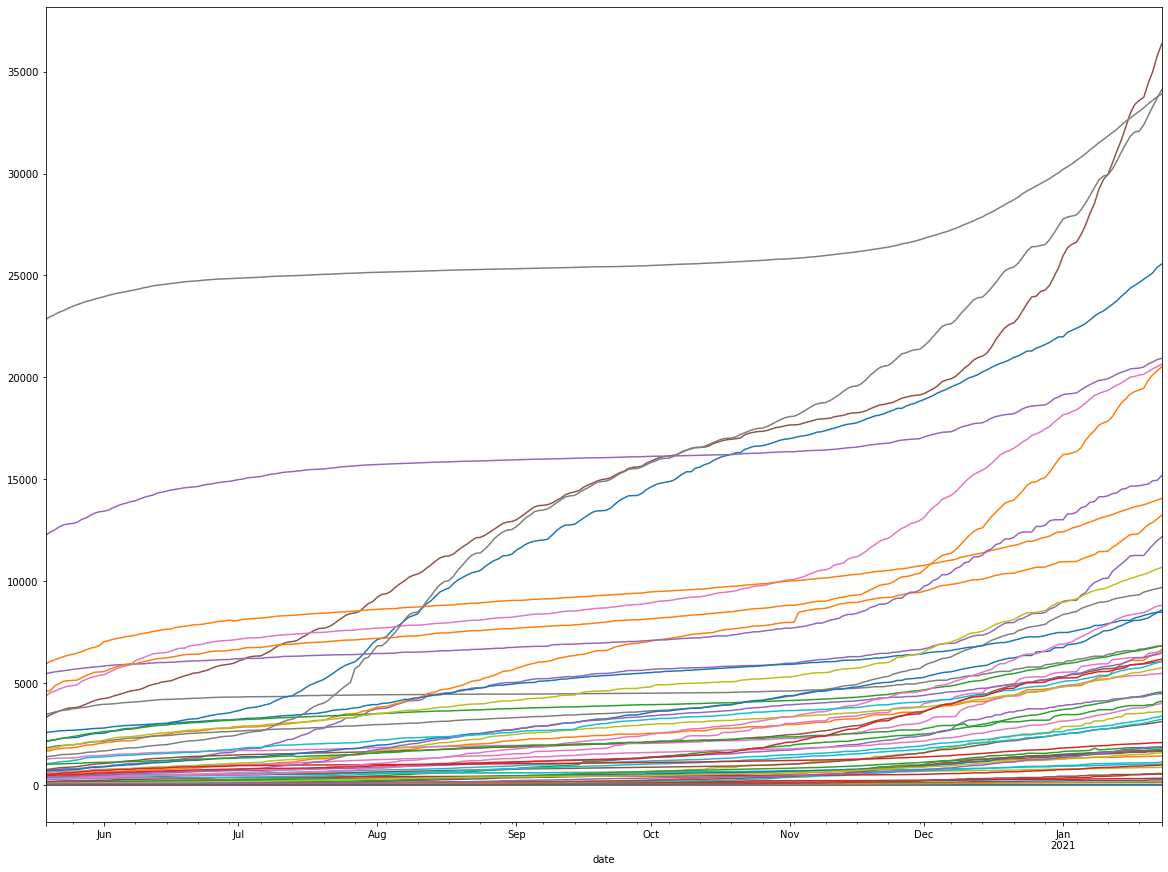

In [107]:
df_states_new = pd.date_range(df_states.index.min(),periods=len(df_states.index),freq='D')

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death
    df_individual.iloc[:250].plot(figsize=(20,15));
    
# print(df_individual)

### Create multiple DataFrames
#### Index and Death Data Only

In [25]:
# df_list = [] # list of state dataframes

In [26]:
# for state in state_postal:
#     print(df_states[df_states['state']==state]) # awesome, now I'm printing each state df one at a time
#     df_list.append(df_states[df_states['state']==state])

In [27]:
# # def create_dataframe_list():
    
# #     for state in state_postal:
# #         df_list.append(df_begin.format(state=state))
            
# df_states[df_states['state']==state])
    
# def create_dataframes(): 
#     for state in state_postal:
#         state = pd.Dataframe(df_states[df_states['state']==state])
    
# # for df in df_list:
# #     print(df)
# #     df = df_states[df_states['state']==state]
# # #     df.plot(figsize=(20,5));

### Plot Alaska Death Count

In [28]:
df_AK = df_states[df_states['state']=='AK'] # let's just use Alaska for now

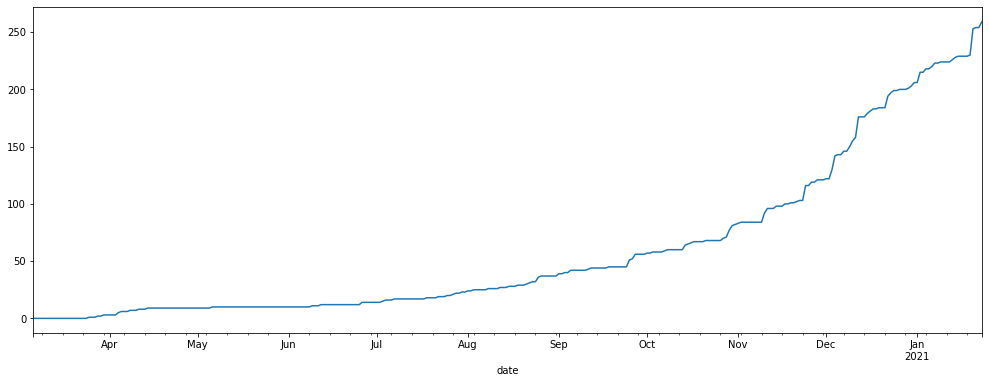

In [29]:
df_AK['death'].plot(figsize=(17,6));

### Hospital Bed and ICU Bed Data (Not updated daily)

In [30]:
# import requests

# url = "https://api.covid19api.com/all"

# payload = {}
# headers= {}

# response = requests.request("GET", url, headers=headers, d= payload)

# print(response.text.encode('utf8'))

In [31]:
# df_bed = pd.read_csv('Data/reference_hospitalization_all_locs.csv',index_col='date',parse_dates=True)

# df_bed.tail()

In [32]:
# df_bed.info()

In [33]:
# df_bed = df_bed.dropna(subset=['deaths_mean'])

In [34]:
# df_bed.columns

In [35]:
# df_bed['location_name'].unique()

### Filter for USA and Global Data (Not updated daily)

In [36]:
# df_USA = df_bed[df_bed['location_name']=='United States of America']
# df_USA = df_USA.filter(regex='mean',axis=1) 

In [37]:
# df_global = df_bed[df_bed['location_name']=='Global']
# df_global = df_global.filter(regex='mean',axis=1) 

In [38]:
# df_USA.columns

In [39]:
# df_USA.head()
# len(df_USA)

In [40]:
# let's look at multiple statistics 

In [41]:
# stats = ['allbed_mean', 'ICUbed_mean', 'InvVen_mean', 'admis_mean',
#        'newICU_mean', 'bedover_mean', 'icuover_mean', 'deaths_mean',
#        'totdea_mean', 'deaths_mean_smoothed', 'totdea_mean_smoothed',
#        'est_infections_mean', 'deaths_mean_p100k_rate', 
#        'est_infections_mean_p100k_rate', 'seroprev_mean']

In [42]:
# for i in stats:
#     ax = df_USA[i].plot(legend=True,figsize=(20,8));
#     ax.axvline(x='2021-01-01',color='r',alpha=.1);

In [43]:
# for i in stats:
#     print(i)
#     plot_acf(df_USA[i],lags=30);
#     plot_pacf(df_USA[i],lags=30);

In [44]:
# from IPython.display import IFrame
# IFrame("Data/IHME_COVID_19_Data_Release_Information_Sheet.pdf", width=1000, height=600)

In [45]:
# # important metrics 
# 'allbed_mean' # total beds with a covid patient 
# 'ICUbed_mean' # ICU beds with a covid patient
# 'InvVen_mean' # ventilators supporting a covid patient
# 'newICU_mean' # mean number of new people in ICU
# 'icuover_mean' # covid ICU beds needed less available ICU capacity
# 'deaths_mean' # mean daily deaths

In [46]:
# graph_list = ['allbed_mean', 'ICUbed_mean', 'InvVen_mean', 'newICU_mean', 'icuover_mean', 'deaths_mean']

In [47]:
# for i in graph_list:
#     ax = df_USA[i].plot(legend=True,figsize=(20,8), title='Covid Bed Requirements and Mean Deaths, USA',
#                    ylabel='Quantity',xlabel='Date')
#     ax.axvline(x='2021-01-01',color='r',alpha=.1);

In [48]:
# df_USA['deaths_mean'].plot(figsize=(15,5)); # take moving average and reinsert to DF

In [49]:
# df_USA.rolling(window=45).mean()['deaths_mean'].plot(figsize=(15,5));

In [50]:
# df_USA['rolling mean'] = df_USA.rolling(window=45).mean()['deaths_mean']

## Modeling and Forecasts

### Auto Regression Models

### Alaska SARIMA Model

In [51]:
df_AK = df_AK.sort_index()

In [52]:
df_AK = df_AK.dropna(subset=['death'])

In [53]:
df_alaska = pd.DataFrame(df_AK)

In [54]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-01-23 00:00:00
Length of dataframe:  324


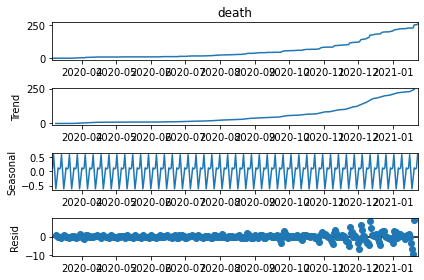

In [55]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [56]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [57]:
stepwise_fit.order

(0, 2, 1)

In [58]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  324
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -705.797
Date:                Sun, 24 Jan 2021   AIC                           1417.593
Time:                        14:05:55   BIC                           1428.917
Sample:                             0   HQIC                          1422.114
                                - 324                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0081      0.006      1.379      0.168      -0.003       0.020
ma.L1         -0.9760      0.011    -88.431      0.000      -0.998      -0.954
sigma2         4.6479      0.156     29.798      0.000       4.342       4.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24803.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              76.63   Skew:                             5.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
length = len(df_alaska)-45

In [60]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [61]:
train_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,AK,NaN,NaN,8.0,1.0,totalTestsViral,8.0,NaN,NaN,NaN,...,8,0,0,1cccb785fe70d960475d4b202a3d0fc678c81e41,0,0,0,0,0,NaN
2020-03-07,AK,NaN,NaN,12.0,2.0,totalTestsViral,12.0,NaN,NaN,NaN,...,12,0,0,a2776acac3d2b1dea060a3c20f4b508d5c00fd3d,0,0,0,0,0,NaN
2020-03-08,AK,NaN,NaN,14.0,6.0,totalTestsViral,14.0,NaN,NaN,NaN,...,14,0,0,ec0512b5cc8703196f5901589feb0640e43a851a,0,0,0,0,0,NaN
2020-03-09,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,1,d079fbd221af733f452c4c09a96059c1b7403d68,0,0,0,0,0,NaN
2020-03-10,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,0,3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-05,AK,34963.0,NaN,1032268.0,NaN,totalTestsViral,1067231.0,166.0,799.0,NaN,...,1067231,1,5,013d9ddc897af4818737f4f7187e540363488dc1,0,0,0,0,0,NaN
2020-12-06,AK,35720.0,NaN,1042056.0,NaN,totalTestsViral,1077776.0,164.0,799.0,NaN,...,1077776,0,0,3cbc5c3774675535dfc4258c3c0a77dd24a54601,0,0,0,0,0,NaN
2020-12-07,AK,36196.0,NaN,1045944.0,NaN,totalTestsViral,1082140.0,166.0,805.0,NaN,...,1082140,3,6,735742382d0c3fad5425354d330d6ca616727d72,0,0,0,0,0,NaN


In [62]:
test_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-12-10,AK,37962.0,NaN,1075398.0,NaN,totalTestsViral,1113360.0,164.0,860.0,NaN,...,1113360,5,13,e74e702804d6b430c17a184b4acbae511972b54c,0,0,0,0,0,NaN
2020-12-11,AK,38584.0,NaN,1084961.0,NaN,totalTestsViral,1123545.0,146.0,869.0,NaN,...,1123545,3,9,ae781d8a2556aad596db12c9f95c3faaa7664ce9,0,0,0,0,0,NaN
2020-12-12,AK,39101.0,NaN,1094317.0,NaN,totalTestsViral,1133418.0,146.0,883.0,NaN,...,1133418,18,14,ef3f2f0abcb797822dd24f9eec0e6993f25943d9,0,0,0,0,0,NaN
2020-12-13,AK,39738.0,NaN,1103360.0,NaN,totalTestsViral,1143098.0,139.0,886.0,NaN,...,1143098,0,3,5bb1f21bb99f720474d81fa05d9f04b51ecb4904,0,0,0,0,0,NaN
2020-12-14,AK,40160.0,NaN,1107400.0,NaN,totalTestsViral,1147560.0,140.0,889.0,NaN,...,1147560,0,3,e5a29d80105d770991491df6181016aba47409ad,0,0,0,0,0,NaN
2020-12-15,AK,40438.0,NaN,1117429.0,NaN,totalTestsViral,1157867.0,140.0,908.0,NaN,...,1157867,3,19,62c0dca8a4bef2c2565d6a16a5ad6d70a573a2c0,0,0,0,0,0,NaN
2020-12-16,AK,41041.0,NaN,1125104.0,NaN,totalTestsViral,1166145.0,146.0,921.0,NaN,...,1166145,2,13,5b761687026839854946df03828dae6122365638,0,0,0,0,0,NaN
2020-12-17,AK,41418.0,NaN,1134305.0,NaN,totalTestsViral,1175723.0,140.0,921.0,NaN,...,1175723,2,0,57da8abfc9d9087026c85e98491d26aa54906809,0,0,0,0,0,NaN
2020-12-18,AK,41905.0,NaN,1143017.0,NaN,totalTestsViral,1184922.0,142.0,928.0,NaN,...,1184922,0,7,50aa2030574b3546c4b6143421d3d5c399bb98dc,0,0,0,0,0,NaN


In [63]:
model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  279
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -514.747
Date:                Sun, 24 Jan 2021   AIC                           1037.494
Time:                        14:05:55   BIC                           1051.990
Sample:                    03-06-2020   HQIC                          1043.310
                         - 12-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0120      0.212     -0.056      0.955      -0.427       0.403
drift          0.0001      0.001      0.156      0.876      -0.002       0.002
ma.L1         -0.6283      0.030    -21.026      0.0

In [64]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [65]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [66]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03',
               '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07',
               '2020-12-08', '2020-12-09'],
              dtype='datetime64[ns]', name='date', length=279, freq=None)

In [67]:
test_data.index

DatetimeIndex(['2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13',
               '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17',
               '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31', '2021-01-01', '2021-01-02',
               '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23'],
              dtype='datetime64[ns]', name='date', freq=None)

In [68]:
predictions_AK = pd.DataFrame(predictions_AK)

In [69]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [70]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [71]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-10 to 2021-01-23
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [72]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-10 to 2021-01-23
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


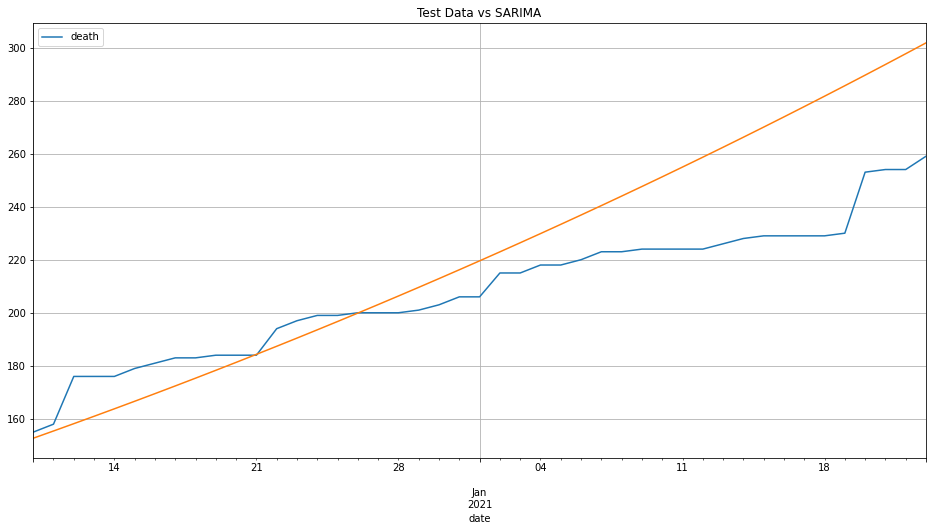

In [73]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [74]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  324
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -727.528
Date:                Sun, 24 Jan 2021   AIC                           1463.056
Time:                        14:05:56   BIC                           1478.154
Sample:                    03-06-2020   HQIC                          1469.083
                         - 01-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0345      0.284     -0.122      0.903      -0.591       0.522
drift          0.0003      0.001      0.228      0.820      -0.002       0.002
ma.L1         -0.7293      0.035    -20.606      0.0

In [75]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

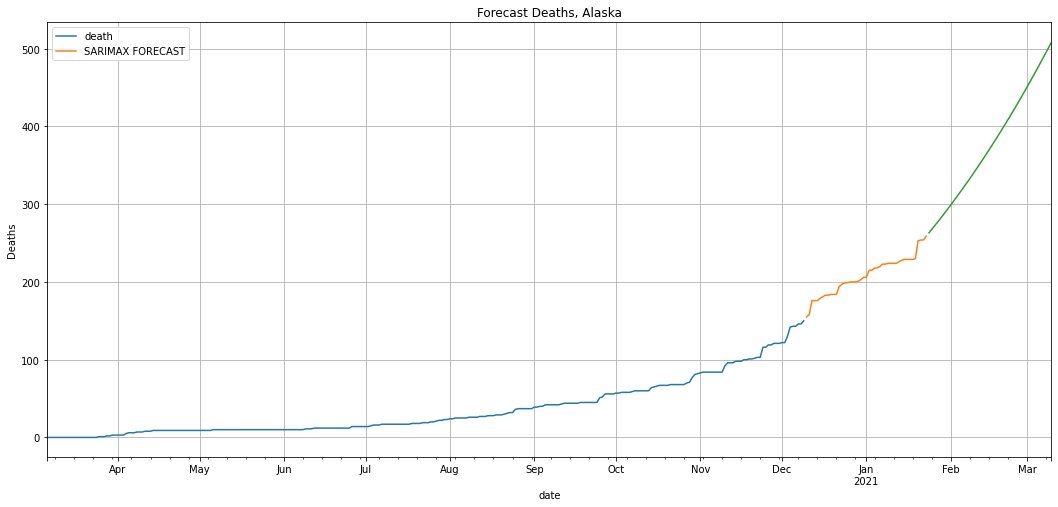

In [76]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

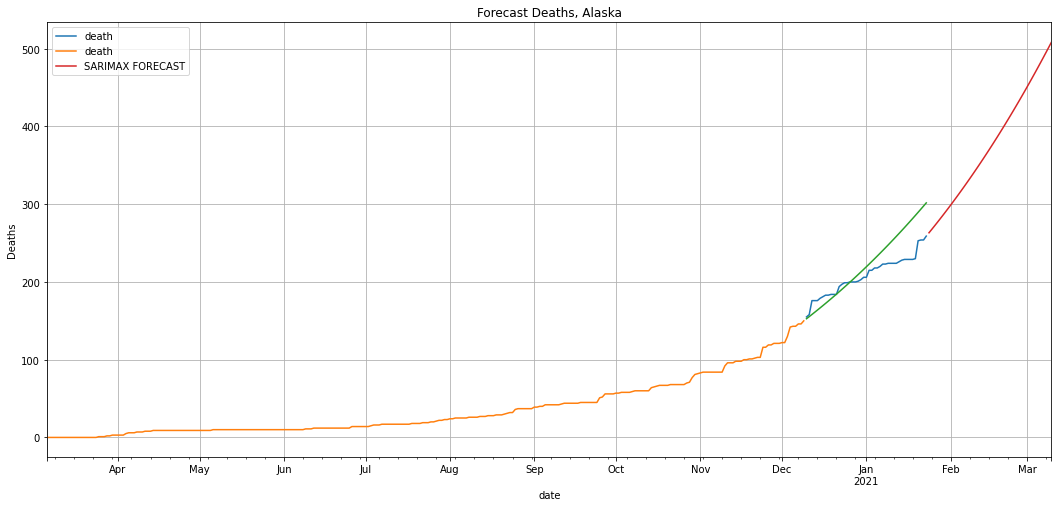

In [77]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

### Dashboard Dev, Work in Progress

In [78]:
# ## getting S&P500 symbols
# import requests
# url= 'https://api.covidtracking.com/v1/states/daily.csv'
# response = requests.get(url)
# response.status_code

In [79]:
# response.

In [80]:
# def summary_states(df_states,state_postal_code,days):
    
#     '''
#     *purpose: creates a SARIMA model based on datetime dataframe with column 'death'
#               and a state postal code under column 'state'
    
#     *inputs:
#     df_states: a dataframe of the state Covid data
#     state_postal_code: state postal code to get state related death data
#     days: number of days out you wish to forecast
#     '''
#     # create dataframe based on state_postal_code
#     df_state = df_states[df_states['state']==state_postal_code]    

#     # sort index, lowest index to oldest date, drop na's in death column
#     df_state = df_state.sort_index()
#     df_state = df_state.dropna(subset=['death'])
#     df_state_new = pd.DataFrame(df_state)

#     # create stepwise fit model, see summary
#     stepwise_fit = auto_arima(df_state_new['death'],start_p=0,start_q=0,max_p=10,
#                               max_q=10, seasonal=True, maxiter=1000, method='bfgs',
#                               n_jobs=-1,stepwise=True) 

#     # auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
#     ## find correct ARIMA order

#     arima_order = stepwise_fit.order

#     length = len(df_state_new)-days

#     df_actuals = df_state_new
#     train_data = df_state_new.iloc[:length]
#     test_data = df_state_new.iloc[length:]

#     model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     start = len(train_data)
#     end = len(train_data) + len(test_data) - 1

#     predictions_state = res.predict(start,end,typ='endogenous').rename(f'SARIMA{arima_order} Predictions')

#     # ensure predictions are in DataFrame format, label index as date to match df_alaska
#     # predictions_state = pd.DataFrame(predictions_state)
#     predictions_state.index.name = 'date'

#     train_data.index.freq = 'D'
#     test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
#     # perform sort_index on dataframe to correct. set frequencies to match for plotting
#     # on same visualization

#     # graph test vs. prediction data - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=4, label=f'SARIMA{arima_order} Predictions')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state);
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'Test Data vs SARIMA, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();

#     # train model for forecast
#     model = sm.tsa.statespace.SARIMAX(df_state['death'],trend='ct', order=arima_order)
#     res = model.fit(disp=False)

#     # create forecast
#     fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days, typ='endogenous').rename(f'SARIMA{arima_order} {days} Days Forecast')

#     # graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
#     legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='r', lw=5, label='Actual Deaths'),
#                        Line2D([0], [0], color='y', lw=5, label=f'SARIMA{arima_order} Predictions'),
#                        Line2D([0], [0], color='g', lw=5, label=f'SARIMA{arima_order} {days} Day Forecast')]

#     fig, ax = plt.subplots(figsize=(20,10));
#     ax.plot(train_data['death'])
#     ax.plot(test_data['death'])
#     ax.plot(predictions_state)
#     ax.plot(fcast)
#     ax.grid(b=True,alpha=.5)
#     plt.title(f'SARIMA {days} Day Forecast, {state_postal_code}')
#     ax.legend(handles=legend_elements)
#     plt.xlabel('Date')
#     plt.ylabel('Deaths')
#     plt.show();
    
#     return df_actuals
#     return fcast # returning fcast to put into plot_forecast

In [81]:
# summary_states(df_states,'CA',30)

In [82]:
# def plot_forecast(df,states=[]):
#     if len(states)==0:
#         states=None
#     pfig = px.line(df)
#     return pfig

In [83]:
# def make_options(menu_choices,ignore_cols=['Date']):
#     """Returns list of dictionary with {'label':menu_choice,'value':menu_choice}"""
#     options = []
#     for choice in menu_choices:
#         if choice not in ignore_cols:
#             options.append({'State':choice,'Postal Code':choice})
#     return options

# state_options = make_options(state_postal)
# make_options(state_postal)

In [84]:
# pio.templates.default = "plotly_dark"

In [85]:
# df_state = df_states[df_states['state']=='CA']    

# # sort index, lowest index to oldest date, drop na's in death column
# df_state = df_state.sort_index()
# df_state = df_state.dropna(subset=['death'])
# df_actuals = pd.DataFrame(df_state)
    
# ## App here
# app = JupyterDash('App2')

# app.layout = html.Div(children=[
#     html.H1('Forecasting'),
#     html.H2('COVID-19 Deaths Forecast'),
#     dcc.Dropdown(id='states',options=state_options,multi=True),
#     dcc.Graph(id=f'{state}',figure=plot_forecast(df_actuals['death'],fcast))])
# app    

# @app.callback(Output('states','figure'),
#               [Input(f'{state}','value')])

# def update_forecast(states,state):
#     return plot_forecast(df_states[f'{state}'])
# app

In [86]:
# today = dt.date.today().strftime("%Y-%m-%d")

# def get_data(start_date=df_states,end_date=today,state_codes=state_postal_code):
    
#     data = {}
#     for state in state_codes:
#         try:
#             data[state] = pdr.DataReader(df_states,'yahoo',start_date,end_date)['death']
#         except:
#             print('Error with stock: '+stock)
#     df = pd.DataFrame(data).reset_index()
#     return df


# def plot_forecast_df(df=None,stocks=['FB','AAPL']):
#     if df is None:
#         df = get_data(stocks)#.reset_index()
#     stocks_exist = [s for s in stocks if s in df.columns]
#     pfig = px.scatter(df,x='Date',y=stocks_exist)
#     return pfig

# from jupyter_plotly_dash import JupyterDash
# app = JupyterDash('Example', 
#                   serve_locally=False)
# defaults = ['MSFT','AMZN']
# # df = get_data(date(2012, 1, 1))

# app.layout = html.Div(children = [
#     html.H1('Our AMAZING Dashboard'),
    
#     html.Div(children=[
#         html.Div(style={"border":'1px solid black','padding':'3px'},id='menu',children=[
#             html.H3('Enter state postal codes, separated by a comma.\nPress Enter to update.'),

#             dcc.Input(id='choose_stocks',value='MSFT,AMZN',
#                       placeholder='MSFT,AAPL',#,
#                          style={'width': '90%', 'height': 50}),           

#             dcc.DatePickerRange( id='my-date-picker-range',
#                                 start_date=date(2012,1,1),
#                                 min_date_allowed=date(2010, 1, 1),
#                                 max_date_allowed=today,#date.today(),#date(2021),
#                                 end_date=today,style={'width':'50%'}),#date.today()), #date(2017, 8, 25)),
#             html.Button('Submit',id='submit',style={'size':'40 px'})
    
#         ]),
        
#         dcc.Graph(id='line_plot')

#     ])
# ])

# @app.callback(Output('line_plot','figure'),
#               [Input('submit','n_clicks')],
#               [State('choose_stocks','value'),
#                State('my-date-picker-range', 'start_date'),
#                State('my-date-picker-range', 'end_date')])
# def update_stocks(n_clicks, stocks,start_date,end_date):
#     stocks = stocks.split(',')
#     plot_df = get_data(start_date,end_date,symbols=stocks)
#     return plot_stocks_df(df=plot_df,stocks=stocks)#,start_date,end_date)
    
# app

In [87]:
# data = {}
# days = 20

# for state in state_postal:
#     cas_state(df_states,state,days)

### Forecast by State, SARIMA

#### Here, provide DataFrame, postal code, and number of days in the future you wish to forecast. Code for this function is in Python file, Cust_Func.py

### Alaska

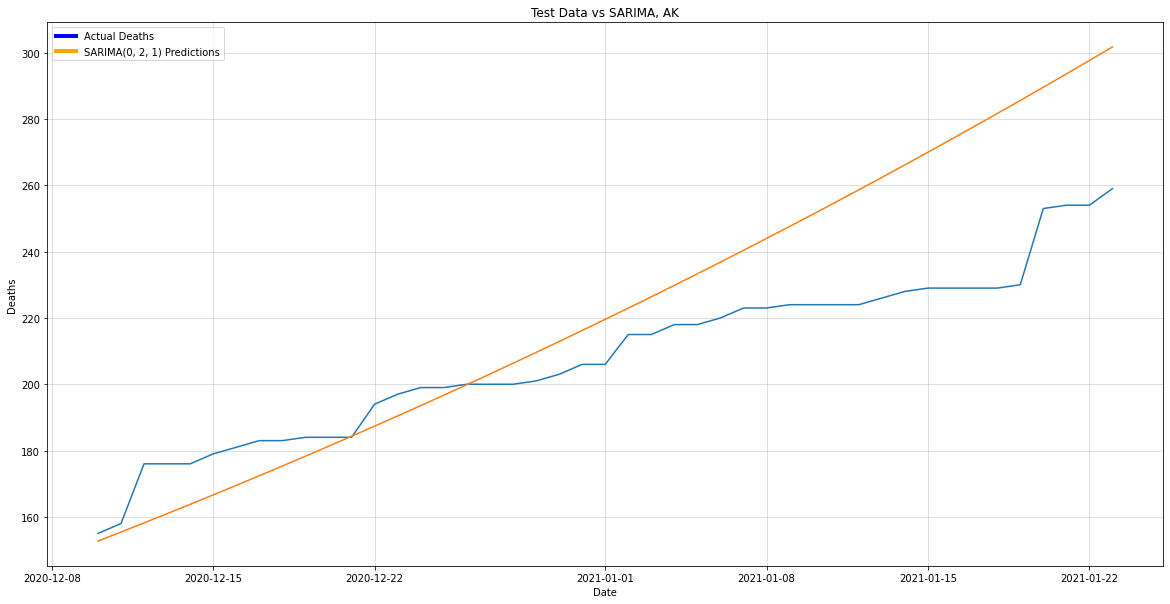

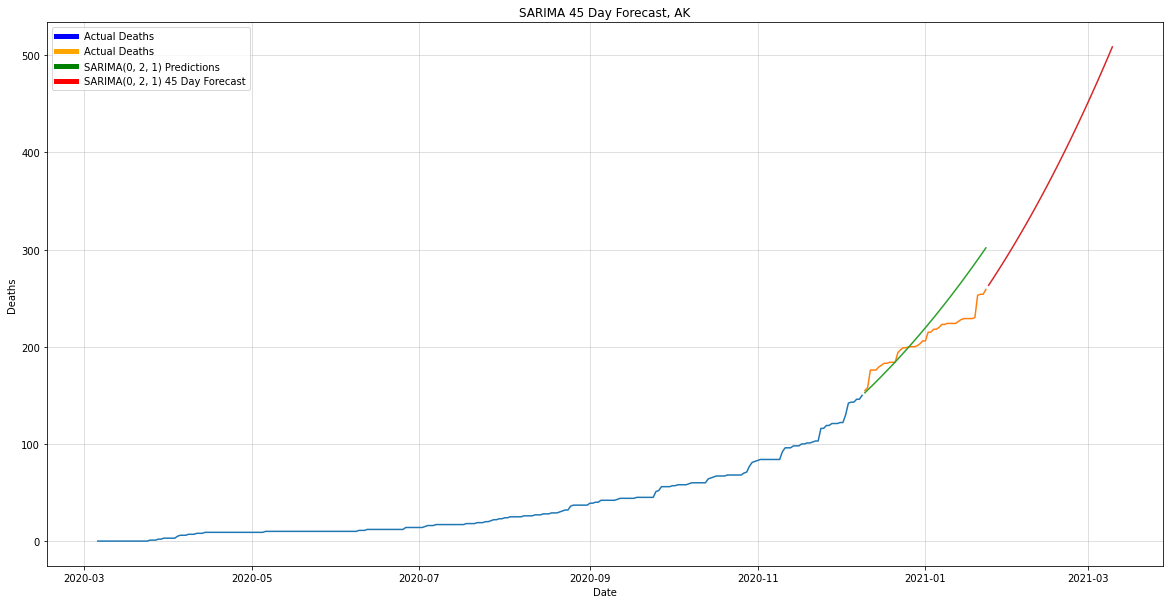

2021-03-06    482.221325
2021-03-07    488.721705
2021-03-08    495.280961
2021-03-09    501.899349
2021-03-10    508.577123
Freq: D, Name: SARIMA(0, 2, 1) 45 Days Forecast, dtype: float64

In [88]:
cas_state(df_states=df_states, state_postal_code='AK',days=45)

### Texas

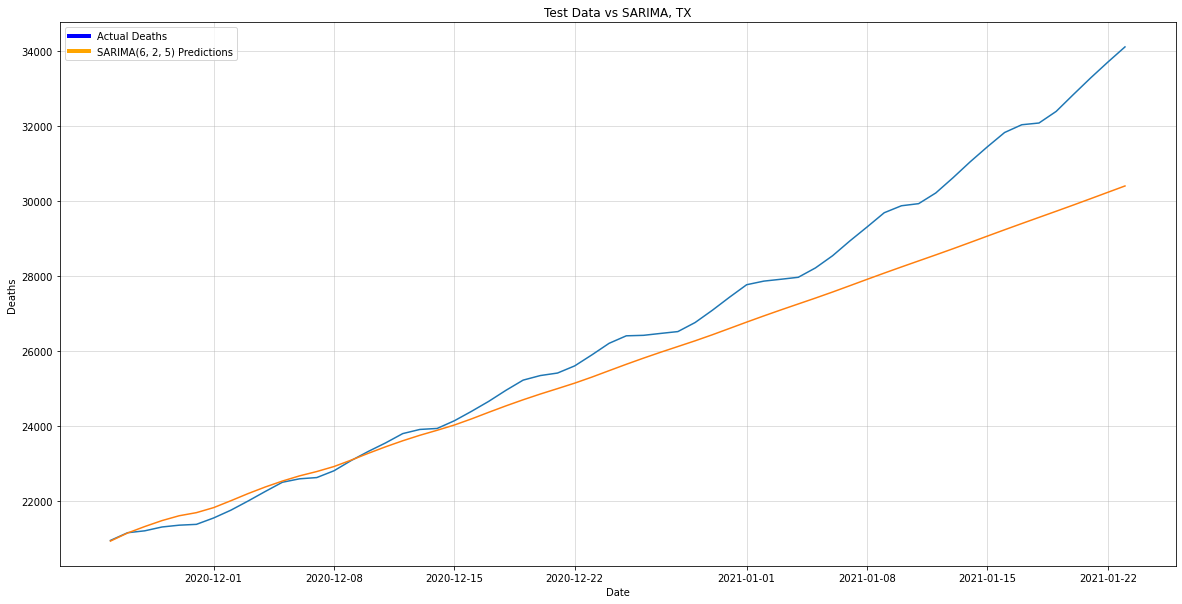

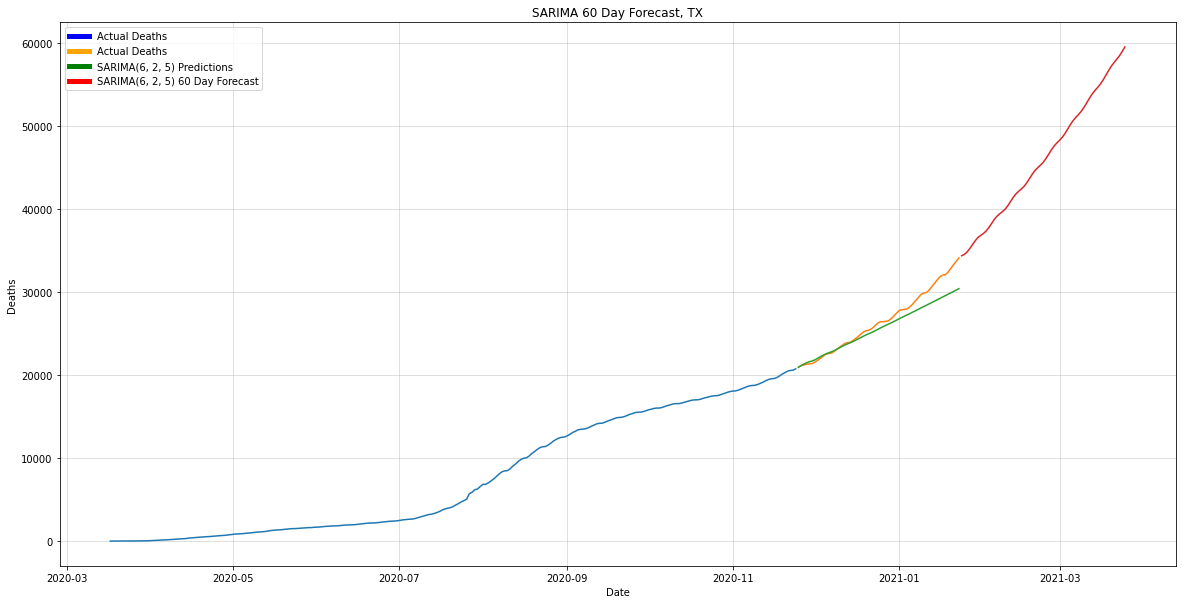

2021-03-21    57633.354578
2021-03-22    58031.202975
2021-03-23    58454.898921
2021-03-24    58955.666533
2021-03-25    59529.078567
Freq: D, Name: SARIMA(6, 2, 5) 60 Days Forecast, dtype: float64

In [89]:
cas_state(df_states=df_states,state_postal_code='TX',days=60) # custom built function in Cust_Func.py

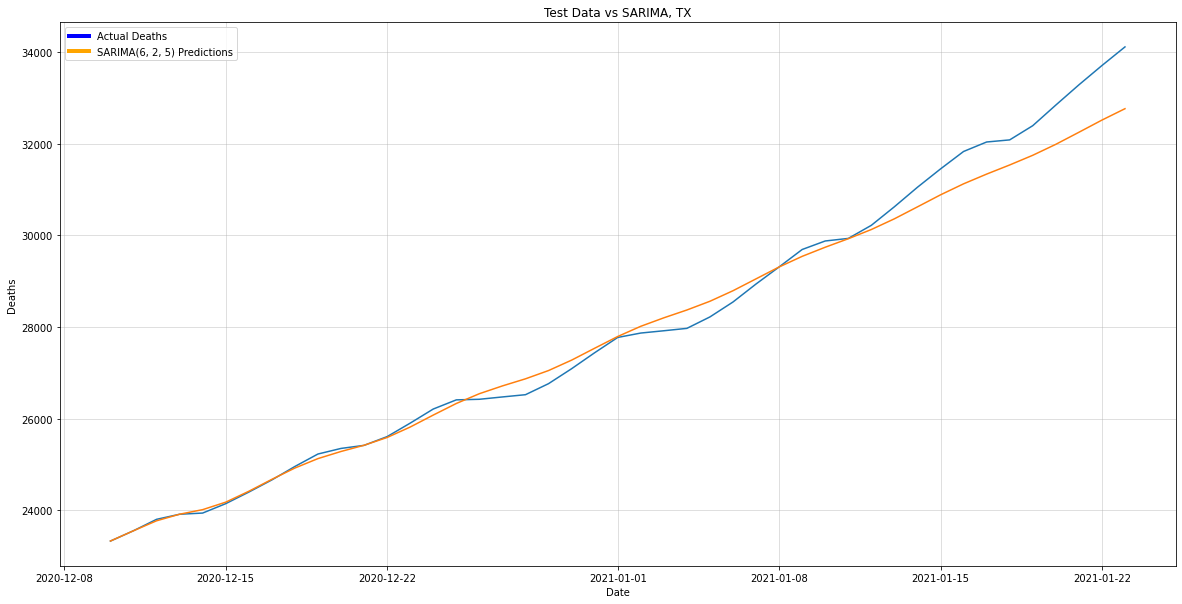

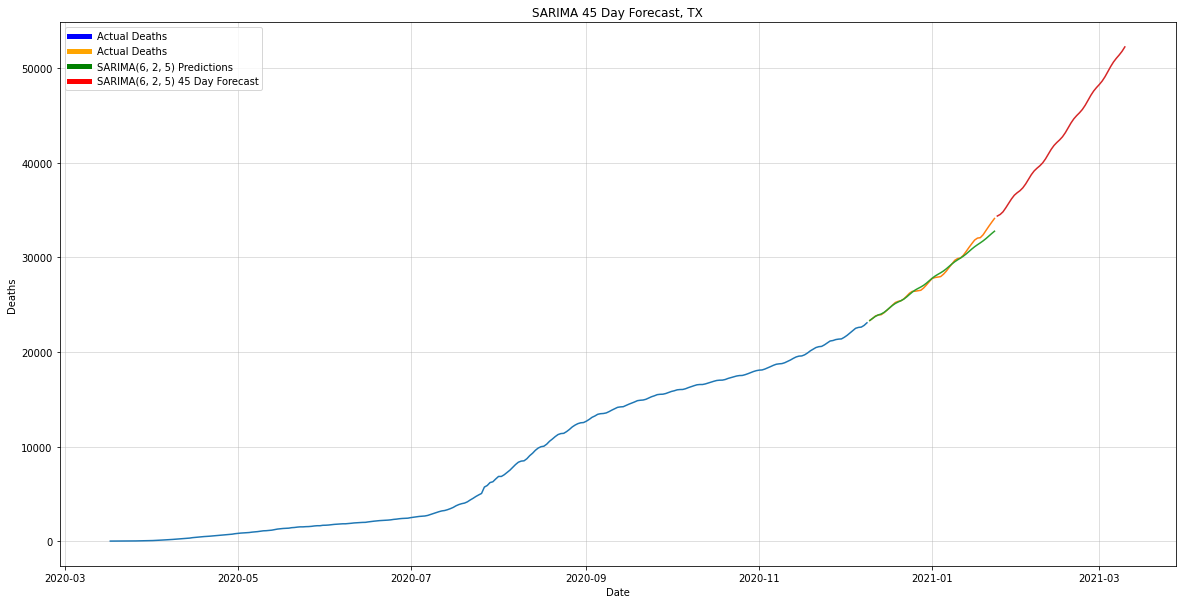

2021-03-06    50660.057570
2021-03-07    51051.263871
2021-03-08    51399.641065
2021-03-09    51782.822852
2021-03-10    52253.536756
Freq: D, Name: SARIMA(6, 2, 5) 45 Days Forecast, dtype: float64

In [90]:
cas_state(df_states=df_states,state_postal_code='TX',days=45)

### Florida

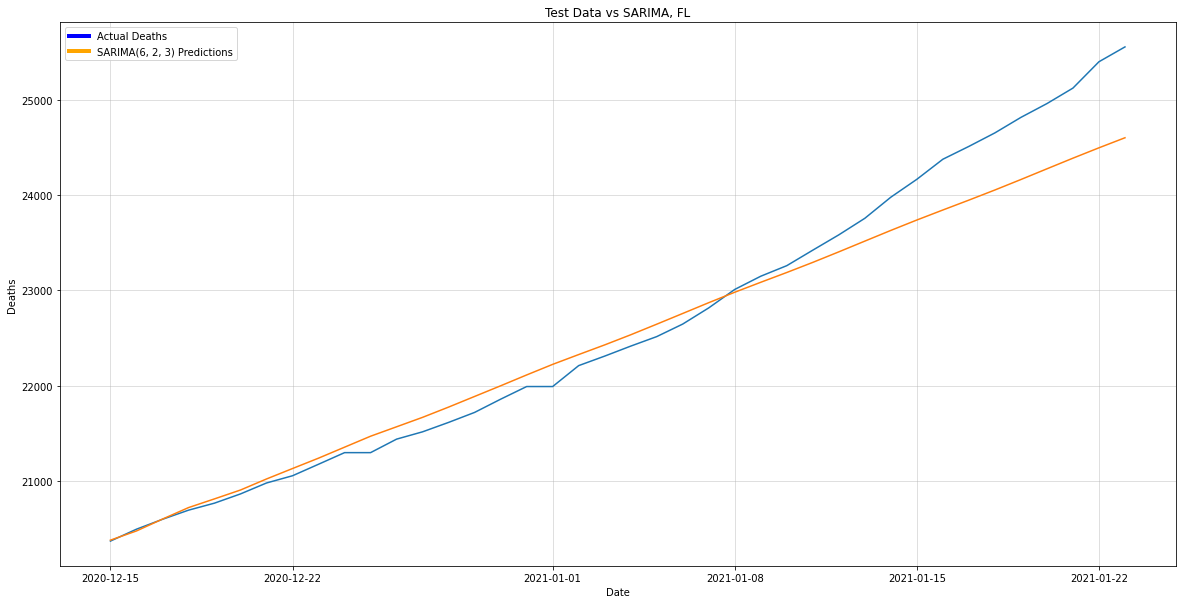

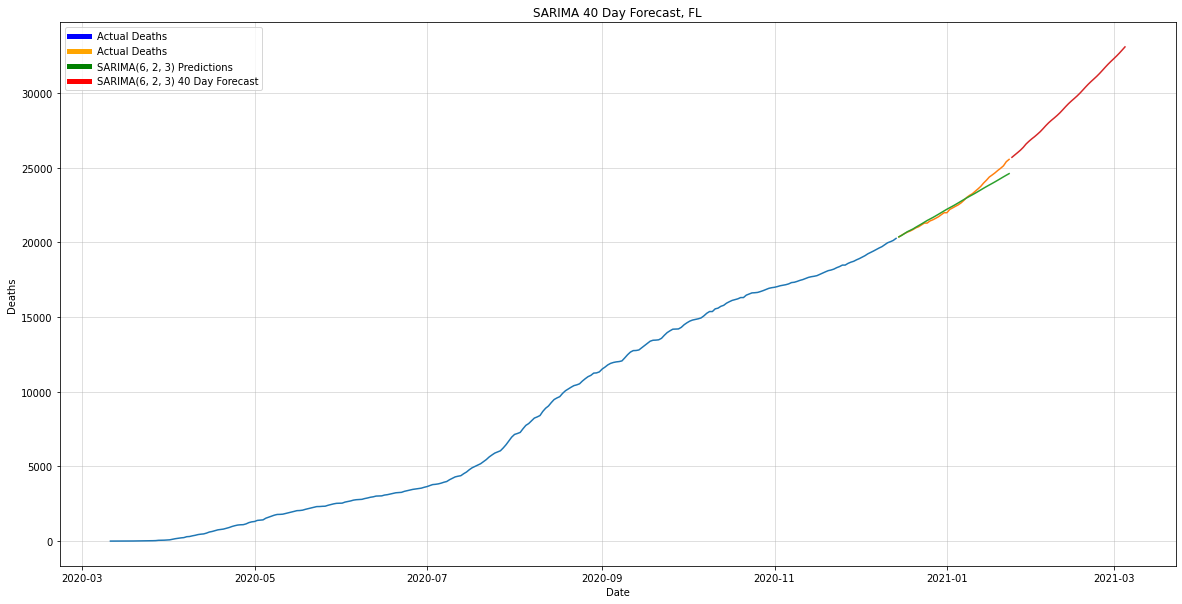

2021-03-01    32295.148028
2021-03-02    32476.975731
2021-03-03    32671.398996
2021-03-04    32878.962534
2021-03-05    33091.184828
Freq: D, Name: SARIMA(6, 2, 3) 40 Days Forecast, dtype: float64

In [91]:
cas_state(df_states,'FL',40)

### New York State

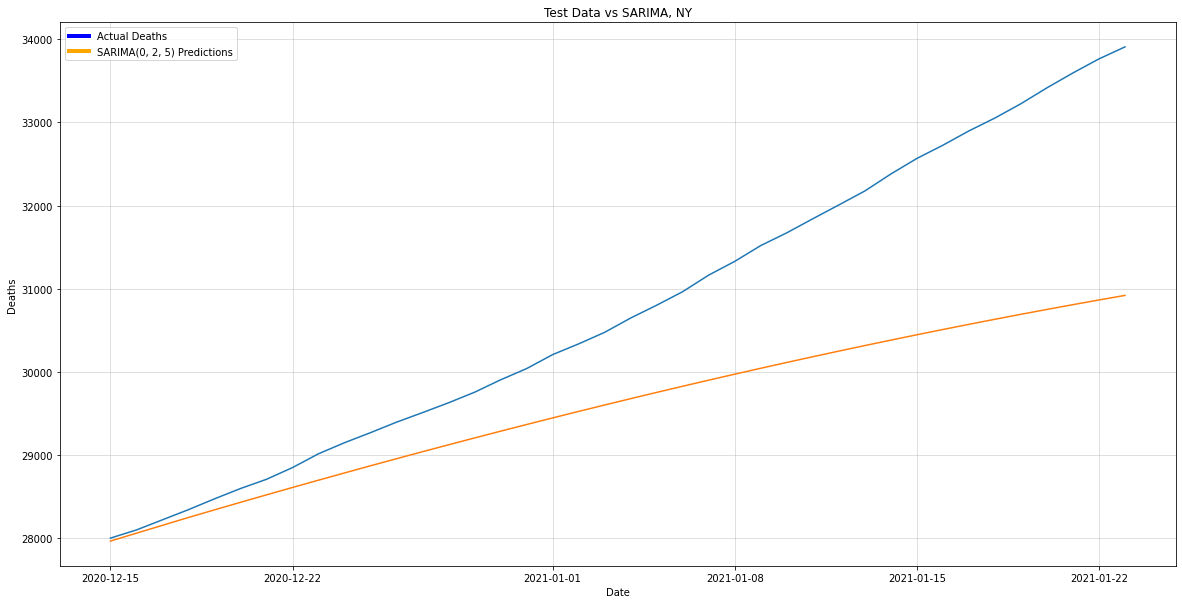

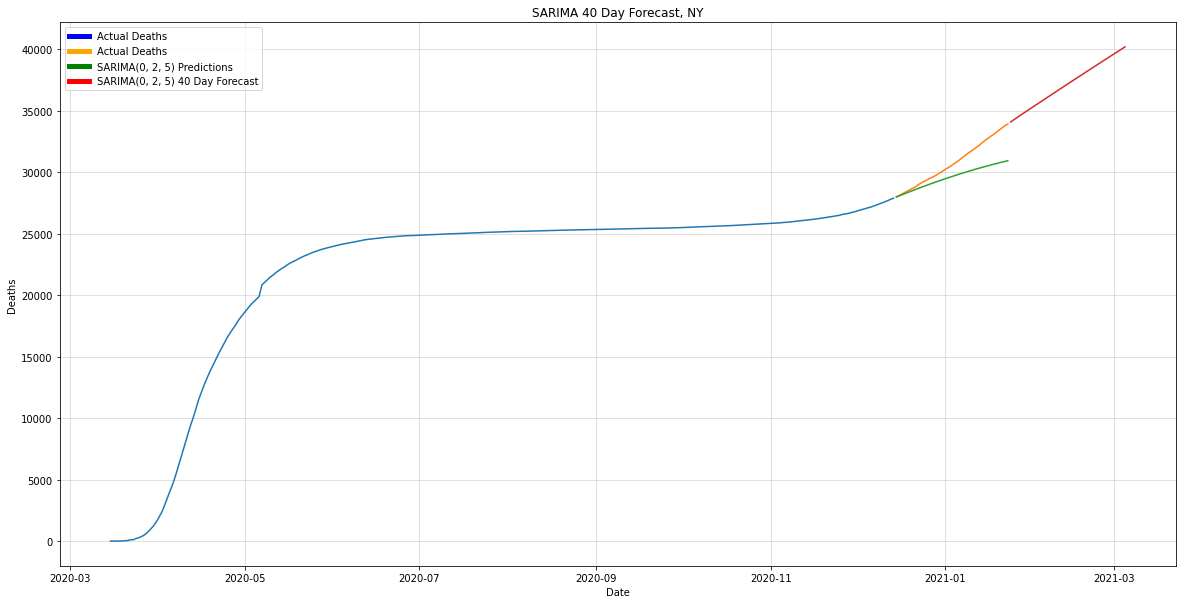

2021-03-01    39578.041383
2021-03-02    39726.986673
2021-03-03    39875.687218
2021-03-04    40024.139195
2021-03-05    40172.338785
Freq: D, Name: SARIMA(0, 2, 5) 40 Days Forecast, dtype: float64

In [92]:
cas_state(df_states,'NY',40)

### California

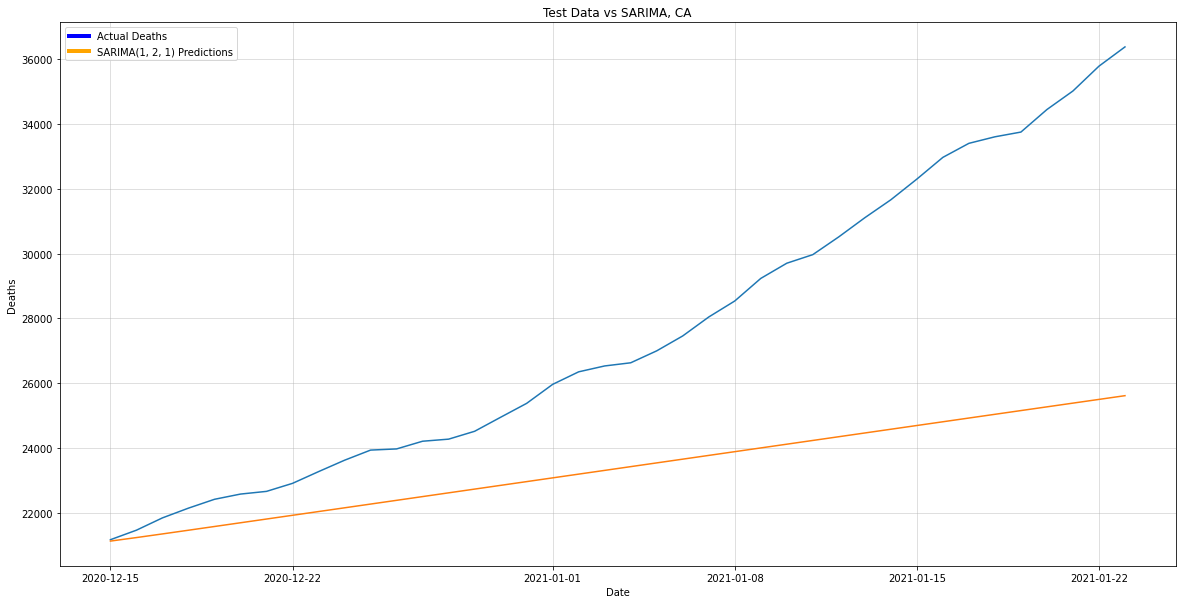

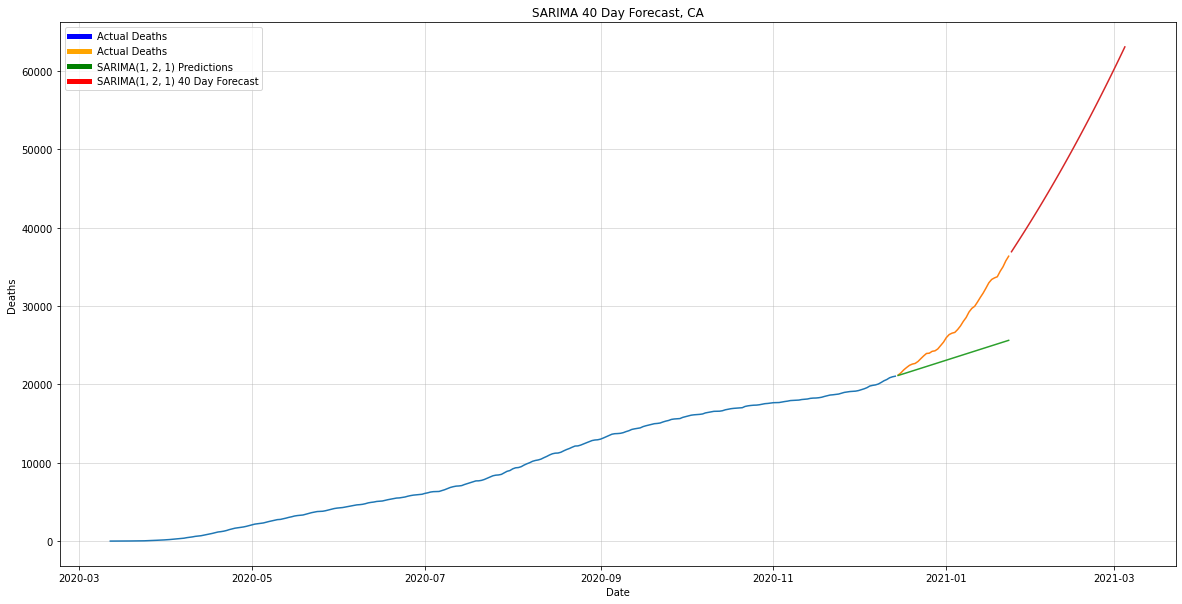

2021-03-01    60072.567187
2021-03-02    60813.457233
2021-03-03    61559.920684
2021-03-04    62311.977473
2021-03-05    63069.647531
Freq: D, Name: SARIMA(1, 2, 1) 40 Days Forecast, dtype: float64

In [93]:
cas_state(df_states,'CA',40)

### Alabama

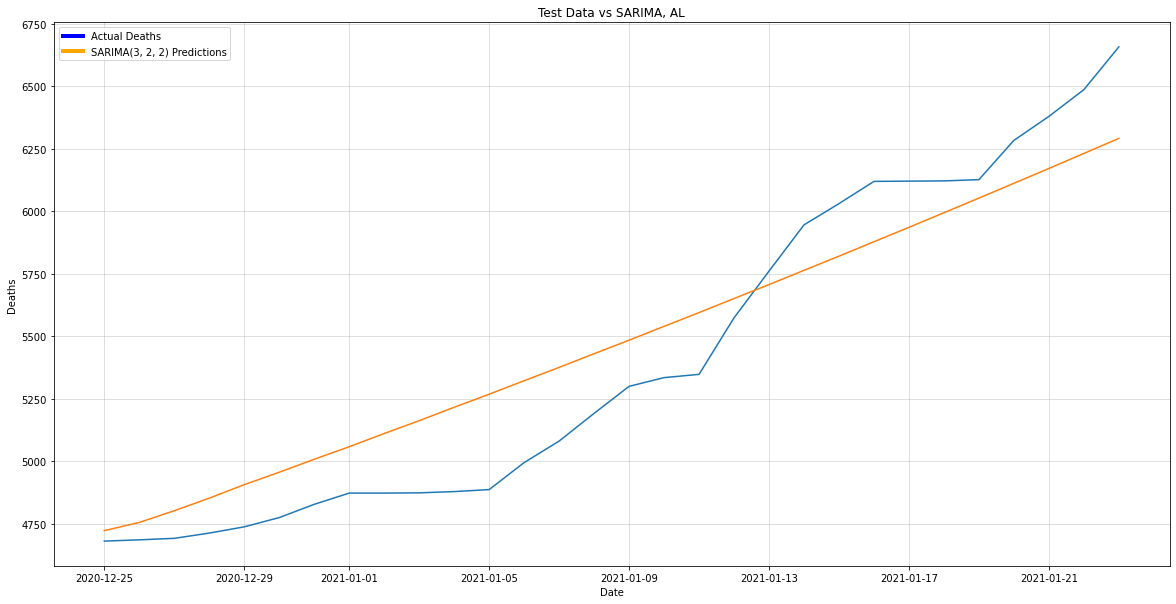

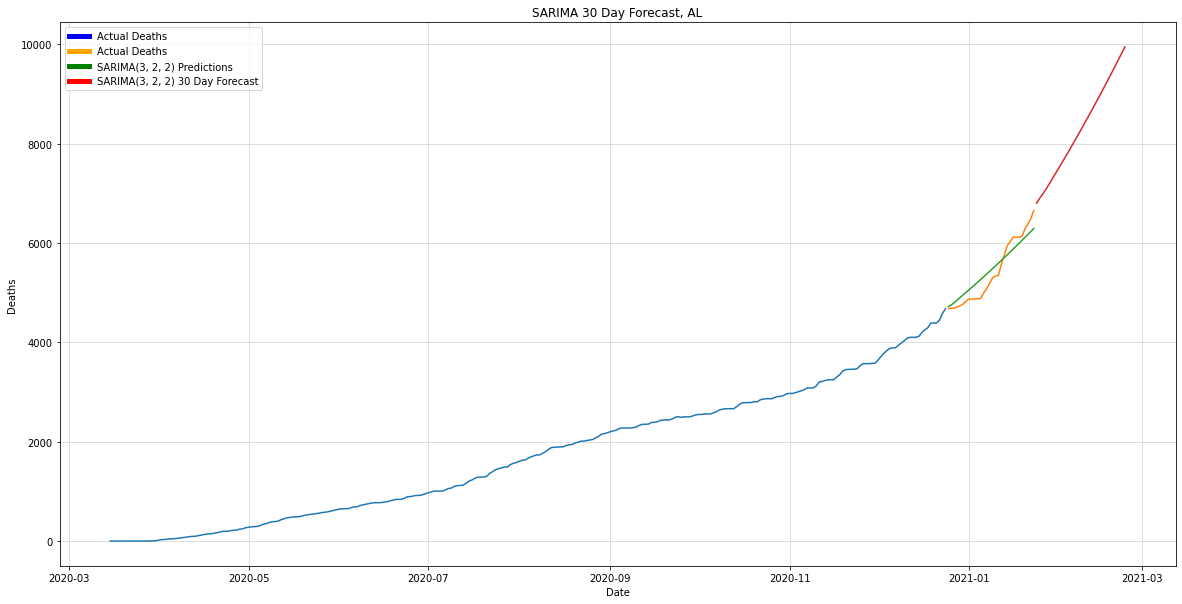

2021-02-19    9481.896484
2021-02-20    9596.885153
2021-02-21    9713.075663
2021-02-22    9829.862552
2021-02-23    9947.786723
Freq: D, Name: SARIMA(3, 2, 2) 30 Days Forecast, dtype: float64

In [94]:
cas_state(df_states,'AL',30)

### Colorado

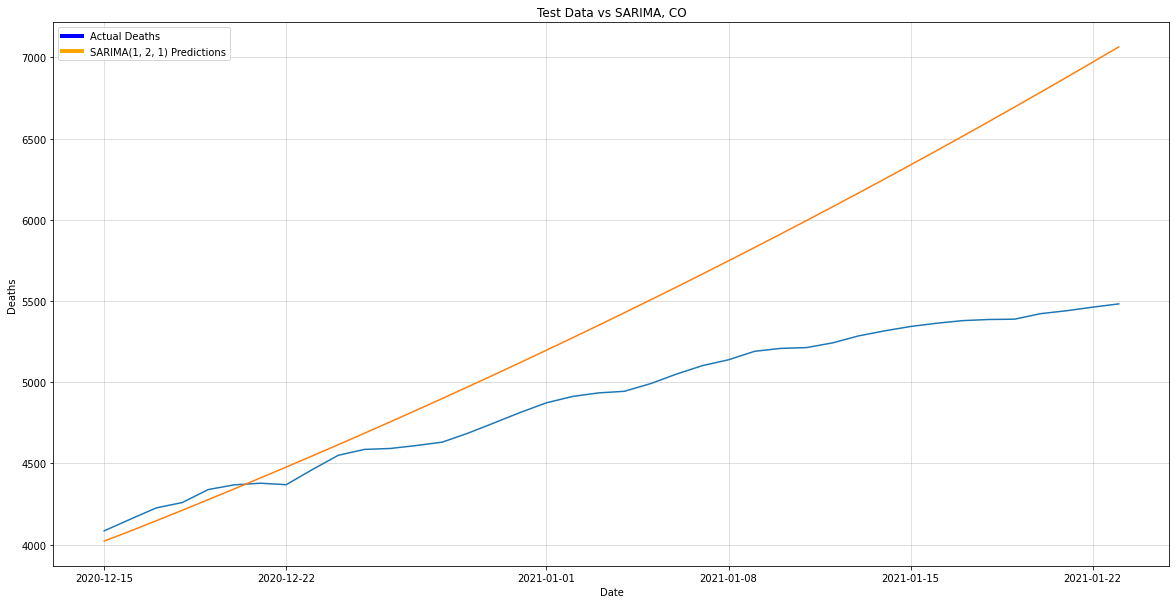

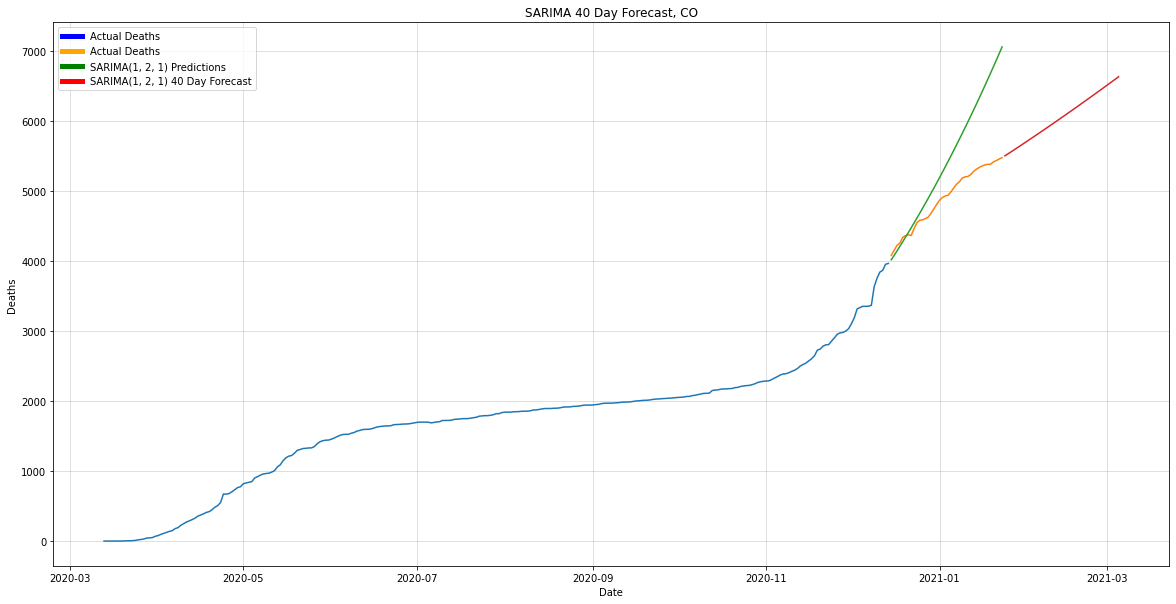

2021-03-01    6518.601255
2021-03-02    6548.281849
2021-03-03    6578.043986
2021-03-04    6607.887362
2021-03-05    6637.811678
Freq: D, Name: SARIMA(1, 2, 1) 40 Days Forecast, dtype: float64

In [95]:
cas_state(df_states,'CO',40)

### All States

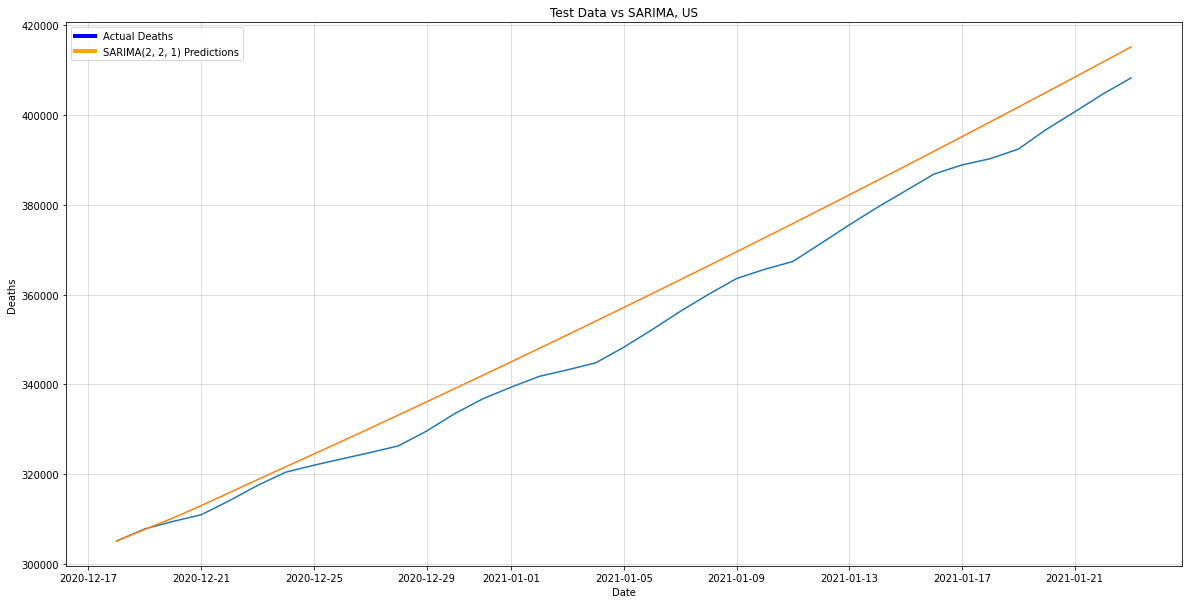

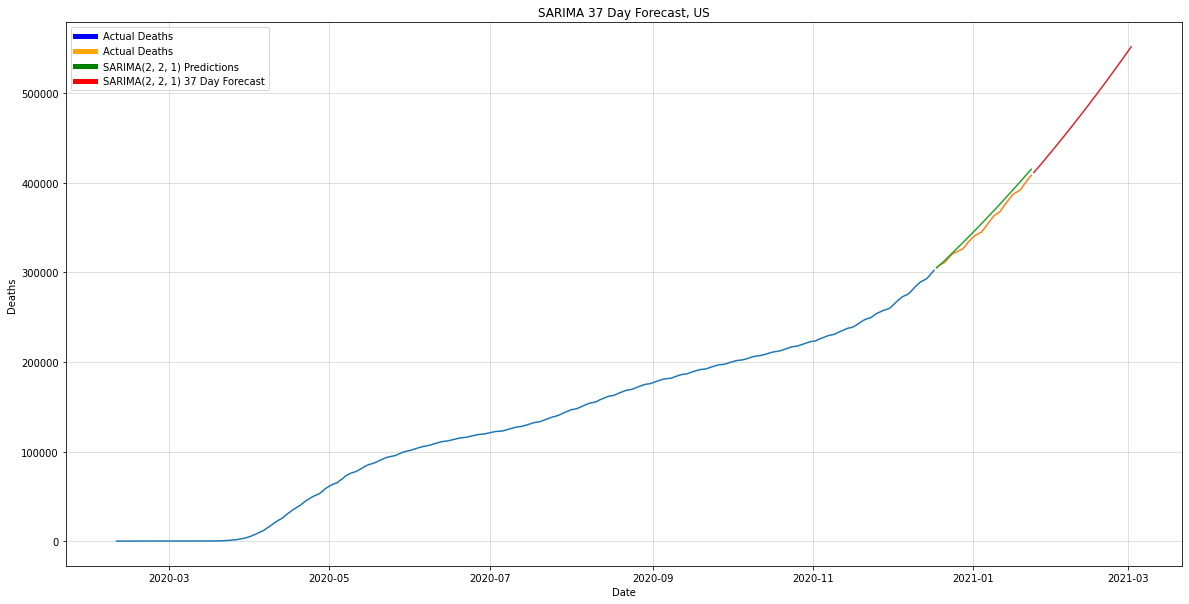

2021-02-26    535154.578264
2021-02-27    539248.399993
2021-02-28    543362.994163
2021-03-01    547498.412754
2021-03-02    551654.708457
Freq: D, Name: SARIMAX(2, 2, 1) Predictions, dtype: float64

In [96]:
cas_usa(df_whole_US,37)

### U.S. Analysis

The graph of cumulative deaths in the United States was fairly steady and linear beginning in March of 2020. The death rate suddenly accelerated in December of 2020 and has continued on that accelerated trend since then. My model projects 540,000 deaths by March, 2021.

Without drastic measures, changes in behavior, and widespread dissemination of the vaccine, this trend will continue and hundreds of thousands more Americans will lose their lives to COVID-19. 

## Univariate Forecast with RNN

### Texas

In [ ]:
create_nn(df_states=df_states,state_postal_code='TX',days=25,epochs=4) # 

### Florida

In [ ]:
create_nn(df_states,'FL',20,epochs=4)

### California

In [ ]:
create_nn(df_states,'CA',20,epochs=4)

## Using an Exogenous Variable with SARIMAX

In [100]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17494 entries, 2021-01-23 to 2020-02-10
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        17494 non-null  object 
 1   positive                     17446 non-null  float64
 2   probableCases                7816 non-null   float64
 3   negative                     17316 non-null  float64
 4   pending                      1658 non-null   float64
 5   totalTestResultsSource       17494 non-null  object 
 6   totalTestResults             17473 non-null  float64
 7   hospitalizedCurrently        15055 non-null  float64
 8   hospitalizedCumulative       11237 non-null  float64
 9   inIcuCurrently               9725 non-null   float64
 10  inIcuCumulative              3276 non-null   float64
 11  onVentilatorCurrently        7743 non-null   float64
 12  onVentilatorCumulative       1121 non-null   float64
 13 

In [101]:
df_states = clean_df(df_states,.05)

### Texas

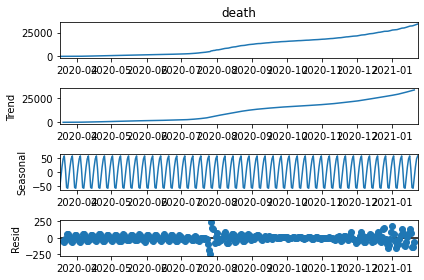

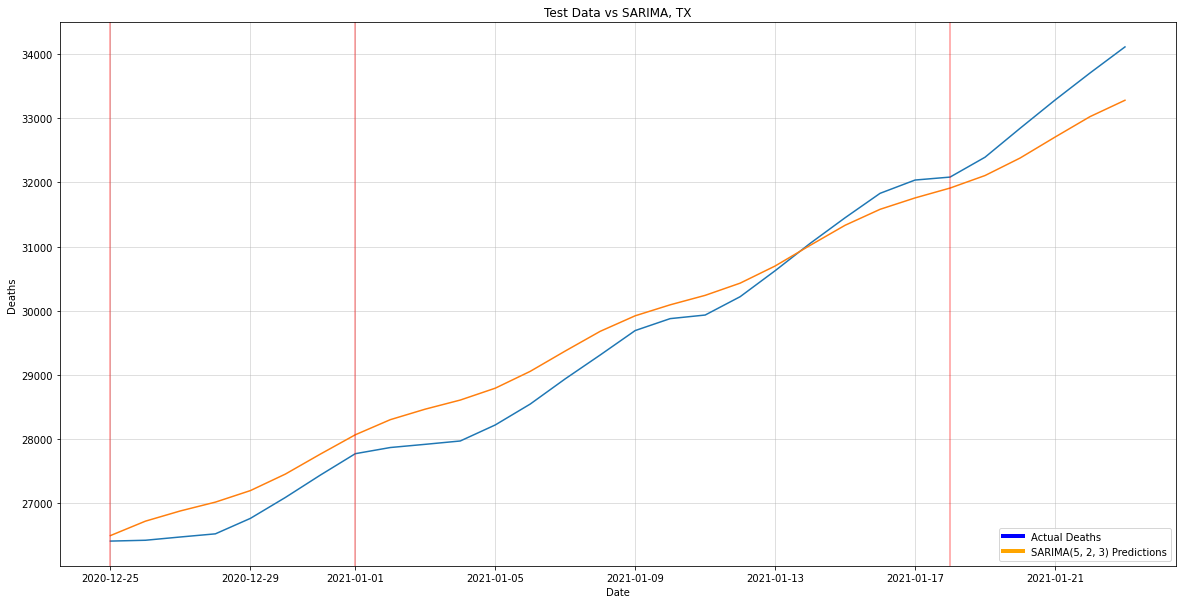

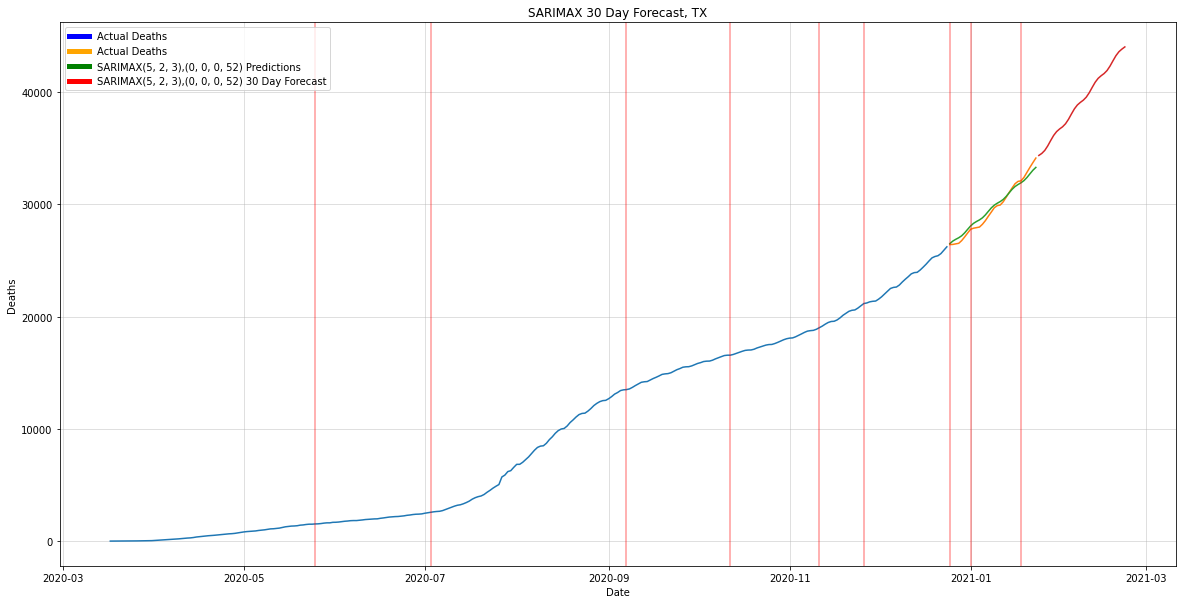

2021-02-18    42777.265019
2021-02-19    43233.680254
2021-02-20    43582.255433
2021-02-21    43815.602231
2021-02-22    44012.735319
Freq: D, Name: SARIMAX(5, 2, 3),(0, 0, 0, 52) 30 Days Forecast, dtype: float64

In [102]:
create_SAX(df_states,'TX',30)

### California

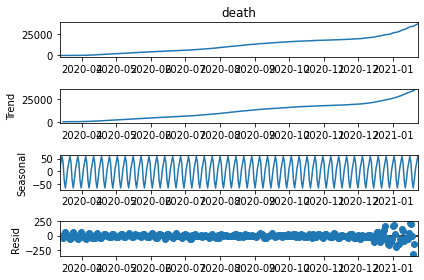

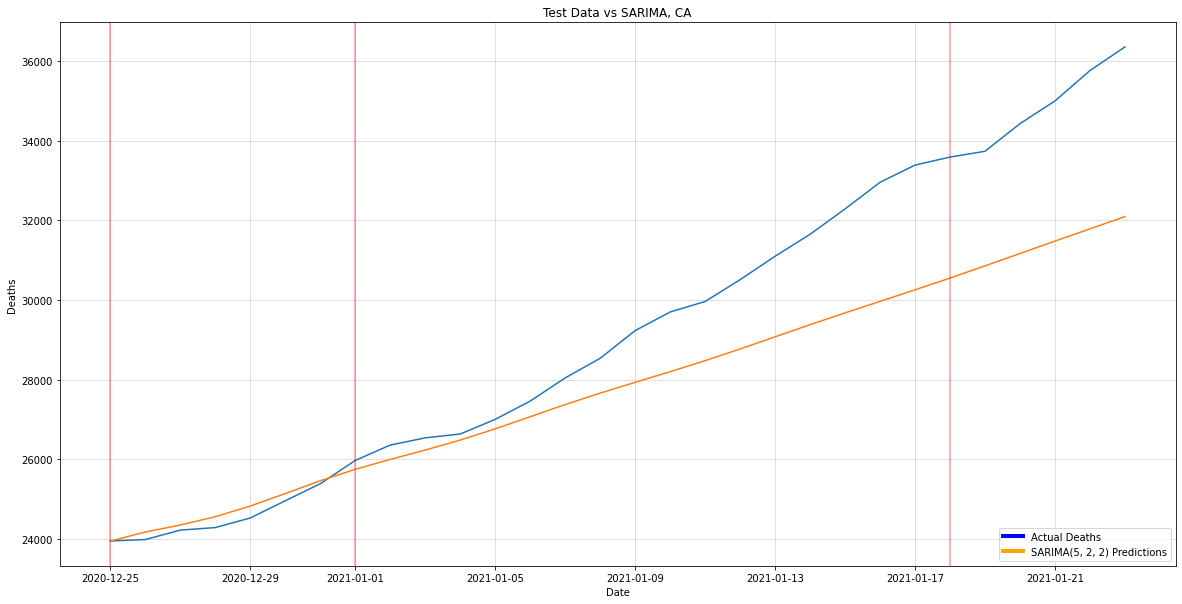

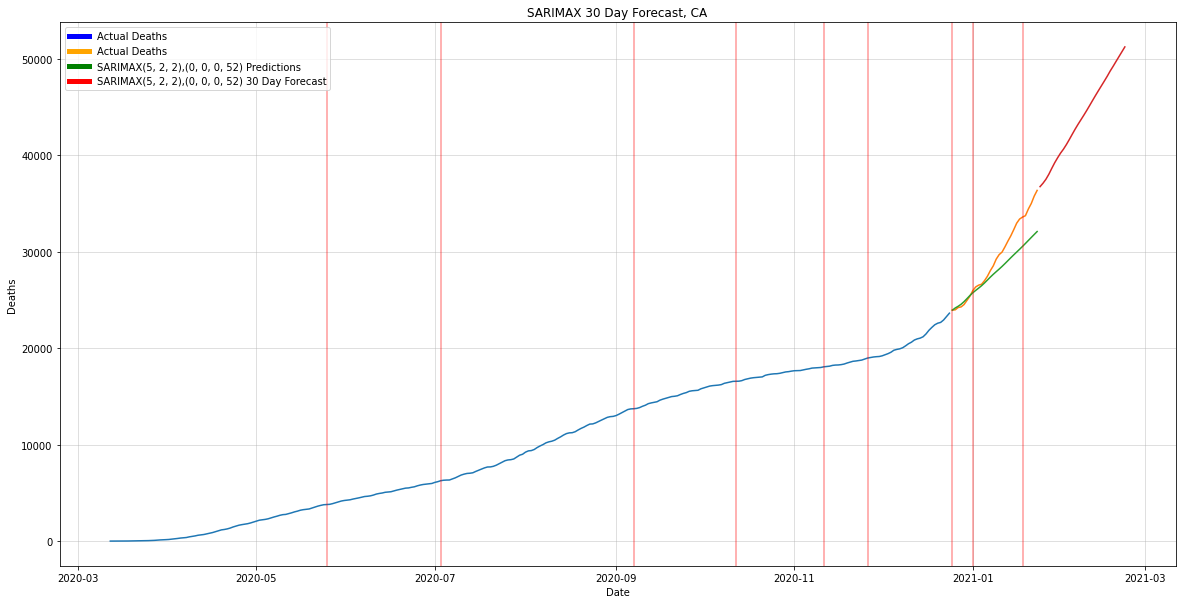

2021-02-18    49229.166012
2021-02-19    49736.418528
2021-02-20    50238.019368
2021-02-21    50736.702852
2021-02-22    51236.681494
Freq: D, Name: SARIMAX(5, 2, 2),(0, 0, 0, 52) 30 Days Forecast, dtype: float64

In [103]:
create_SAX(df_states,'CA',30)

### Florida

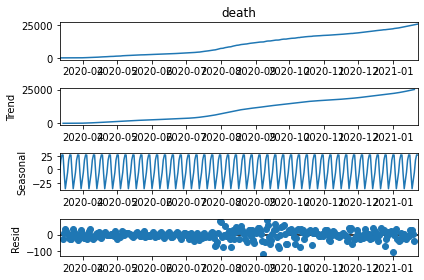

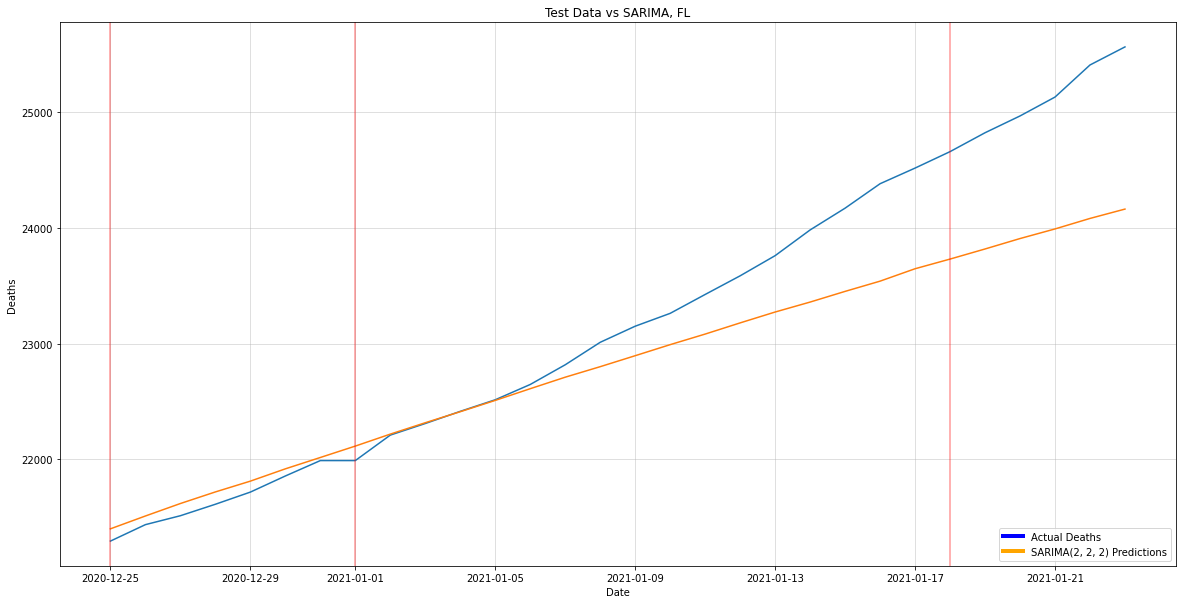

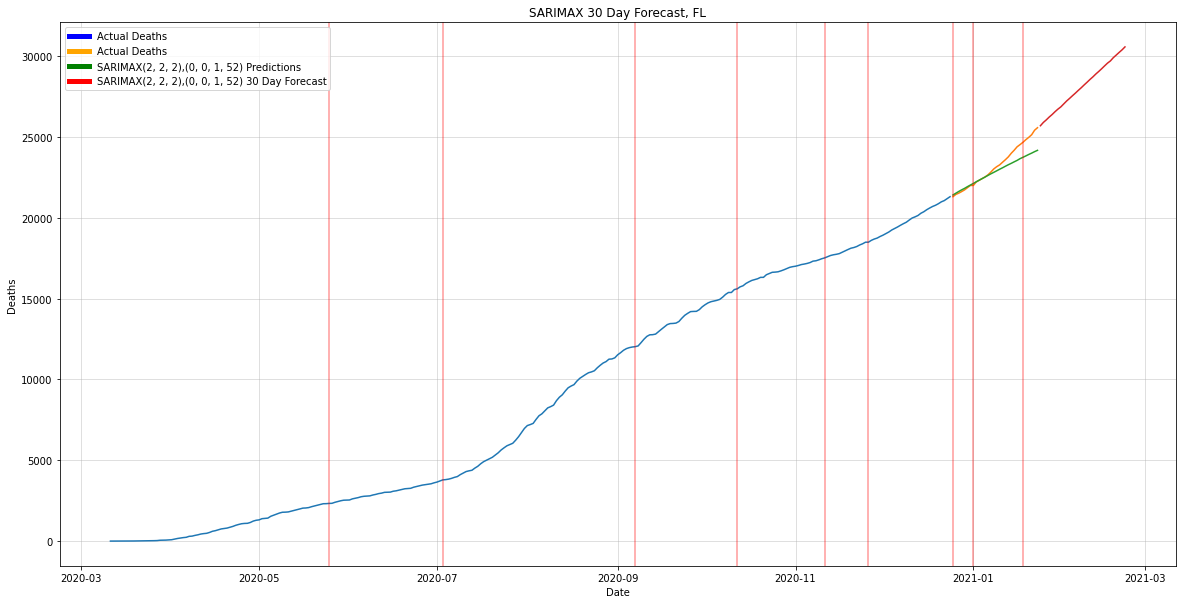

2021-02-18    29889.875174
2021-02-19    30051.308977
2021-02-20    30215.853812
2021-02-21    30373.565311
2021-02-22    30555.699813
Freq: D, Name: SARIMAX(2, 2, 2),(0, 0, 1, 52) 30 Days Forecast, dtype: float64

In [104]:
create_SAX(df_states,'FL',30)

### All States

NameError: name 'state_postal_code' is not defined

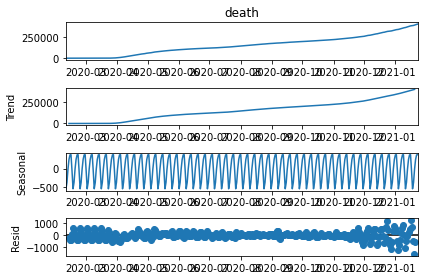

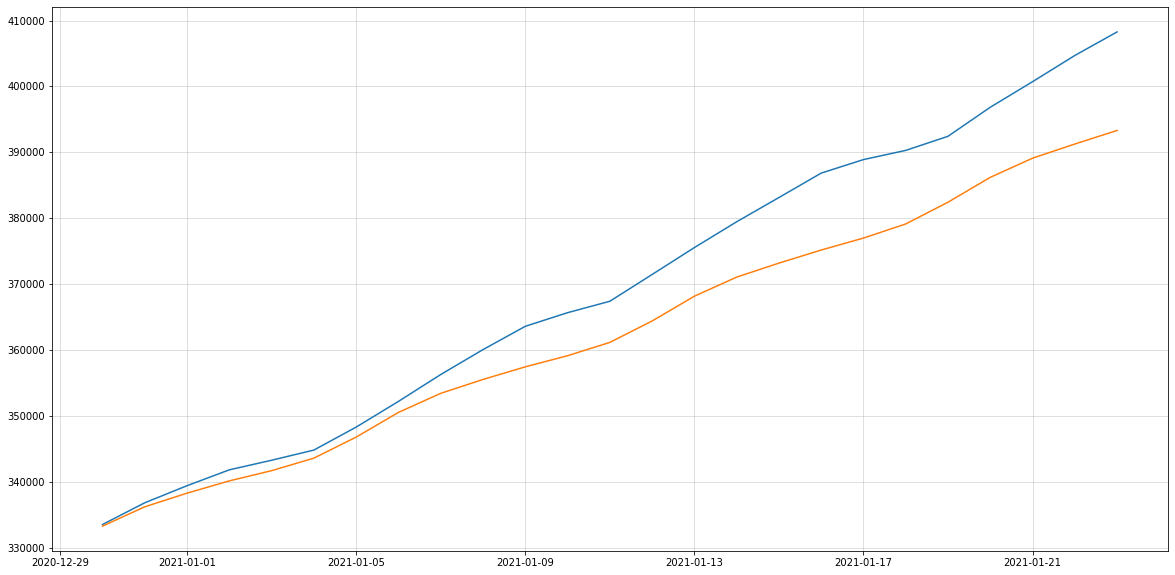

In [106]:
create_SAX_usa(df_whole_US,25)

## Questions

### Question 1

### Question 2

### Question 3

## Conclusions

## Future Work